In [1]:
%matplotlib inline
from __future__ import division, print_function, unicode_literals

from pylab import *
from numpy import random
from numpy import fft
from matplotlib import gridspec

# Introduction to Pulsar Timing

###Matteo Bachetti

<img src="0737.png" alt="Buried Clock" style="height: 300px;margin: auto;"/>

(These slides are obtained from the iPython notebook that can be found [here](https://bitbucket.org/mbachett/timing-lectures))

## Contents

* Finding pulsars: the buried clock

* Frequency analysis: the Fourier Transform and the Power Density Spectrum

* Refine the search: Folding search (+ $Z^2_n$, $H$-test, ...)

* Getting pulse arrival times 

# Finding pulsars: the buried clock

<img src="buriedclock.jpg" alt="Buried Clock" style="height: 300px;margin: auto;"/>



# Finding pulsars: the buried clock

* Pulsars are stable rotators: very predictable "clocks"

<img src="smallmodpulsar.gif" alt="Pulsar" style="height: 300px;margin: auto;"/>

# Finding pulsars: the buried clock

* Pulsars are stable rotators: very predictable "clocks"

* Often signal buried in noise (below: a 0.853-Hz sinusoidal pulse buried in noise ~30 times stronger)

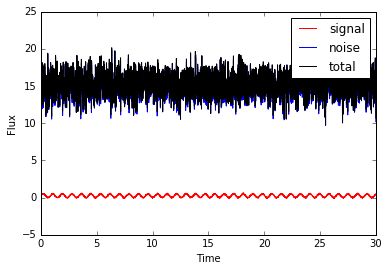

In [19]:
def pulsar(time, period=1):
    return (1 + sin(2 * pi / period * time)) / 2.

time_bin = 0.009

# --- Parameters ----
period = 0.8532
pulsar_amp = 0.5
pulsar_stdev = 0.05
noise_amp = 15
noise_stdev = 1.5
# --------------------

# refer to the center of the time bin
time = arange(0, 100, time_bin) + time_bin / 2
signal = pulsar(time, period)
signal = random.normal(pulsar_amp * signal, pulsar_stdev)
plot(time, signal, 'r-', label='signal')
noise = random.normal(noise_amp, noise_stdev, len(time))
total = signal + noise
plot(time, noise, 'b-', label='noise')
plot(time, total, 'k-', label='total')
xlim(0, 30)
xlabel('Time')
ylabel('Flux')
a = legend()

# Frequency analysis: the Fourier Transform

Through the Fourier transform, we can decompose a function of time into a series of functions of frequency:

\begin{equation}
\mathcal{F}(\omega) = \int^{\infty}_{-\infty} e^{-i\omega t} f(t)
\end{equation}

or, more appropriate to our case, in the discrete form, we can decompose a time series into a frequency series:

\begin{equation}
F_k = \sum^{N-1}_{k=0} e^{-2\pi i k n/N} t_n
\end{equation}

it is, in general, a **complex** function.

The Fourier transform of a sinusoid will give a high (in absolute terms) value of the $F_k$ corresponding to the frequency of the sinusoid. Other periodic functions will produce high contribution at the fundamental frequency plus one or more multiples of the fundamental, called *harmonics*.


## Our example

Let's take the Fourier transform of the signal we simulated above (only taking *positive* frequencies)

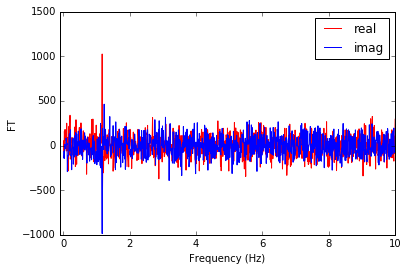

In [12]:
ft = fft.fft(total)
freqs = fft.fftfreq(len(total), time_bin)
good = freqs >0
freqs = freqs[good]
ft = ft[good]
plot(freqs, ft.real, 'r-', label='real')
plot(freqs, ft.imag, 'b-', label='imag')
xlim([-0.1, 10])
a = legend()
_ = xlabel('Frequency (Hz)')
_ = ylabel('FT')

Note that the imaginary part and real part of the Fourier transform have different contributions at the pulsar frequency (1/0.85 s ~ 1.2 Hz). This is because they depend strongly on the phase of the signal [Exercise: **why?**].

## Our example - 2

 If we applied a shift of 240 ms (just any value) to the signal:

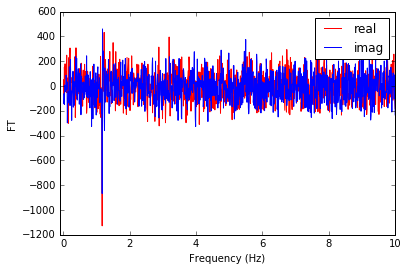

In [13]:
shift = 0.240
signal_shift = roll(total, int(shift / time_bin))
ft_shift = fft.fft(signal_shift)
freqs_shift = fft.fftfreq(len(total), time_bin)
good = freqs_shift >0
freqs_shift = freqs_shift[good]
ft_shift = ft_shift[good]
plot(freqs_shift, ft_shift.real, 'r-', label='real')
plot(freqs_shift, ft_shift.imag, 'b-', label='imag')
xlim([-0.1, 10])
a = legend()
_ = xlabel('Frequency (Hz)')
_ = ylabel('FT')

we would clearly have non-zero values at ~0.85 Hz both in the real and the imaginary parts.

# The Power Density Spectrum

To solve these issues with real and imaginary parts, we can instead take the *modulus* of the Fourier transform. This is called **Power Spectrum**

\begin{equation}
\mathcal{P}(\omega) = \mathcal{F}(\omega) \cdot \mathcal{F}^*(\omega)
\end{equation}

this function is positive-definite and in our case results in a clear peak at the pulse frequency, *consistent* between original and shifted signal:

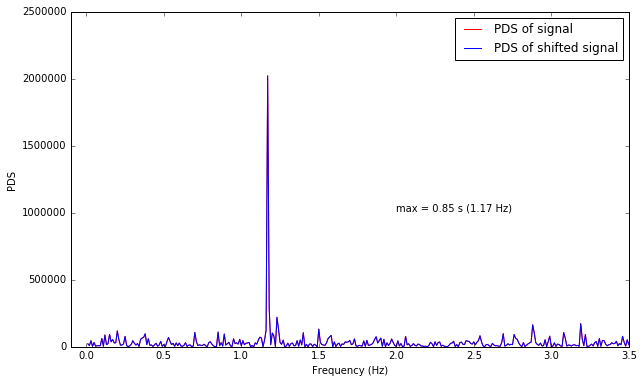

In [15]:
pds = absolute(ft) ** 2
pds_shift = absolute(ft_shift) ** 2

figure(figsize=(10, 6))
plot(freqs, pds, 'r-', label='PDS of signal')
plot(freqs_shift, pds_shift, 'b-', label='PDS of shifted signal')
a = legend()
a = xlabel('Frequency (Hz)')
a = ylabel('PDS')
fmax = freqs[argmax(pds)]
pmax = 1 / fmax
xlim([-0.1, 3.5])
_ = gca().annotate('max = {:.2f} s ({:.2f} Hz)'.format(pmax, fmax), xy=(2., max(pds) / 2))

## The Power Density Spectrum -2

The PDS of a generic non-sinusoidal pulse profile will, in general, contain more than one harmonic, with the fundamental not always predominant.

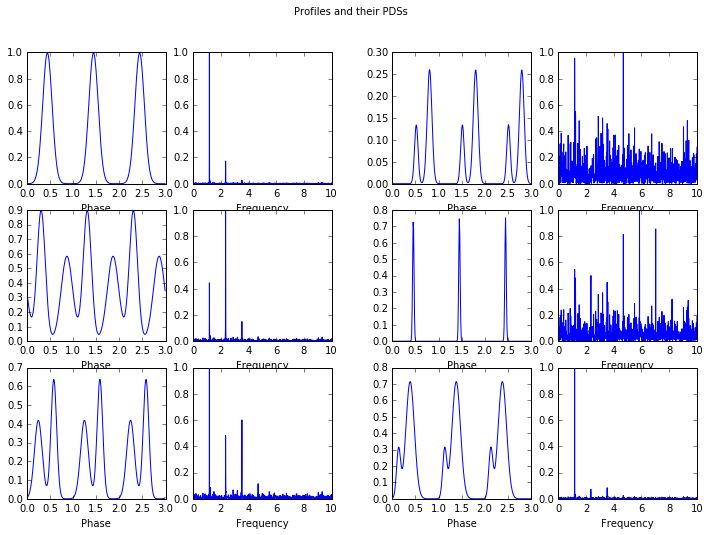

In [17]:
def gaussian_periodic(x, x0, amp, width):
    '''Approximates a Gaussian periodic function by summing the contributions in the phase
    range 0--1 with those in the phase range -1--0 and 1--2'''
    phase = x - floor(x)
    lc = zeros_like(x)
    for shift in [-1, 0, 1]:
        lc += amp * exp(-(phase + shift - x0)**2 / width ** 2)
        
    return lc

def generate_profile(time, period):
    '''Simulate a given profile with 1-3 Gaussian components'''
    total_phase = time / period
    ngauss = random.randint(1, 3)
    lc = np.zeros_like(total_phase)
    for i in range(ngauss):
        ph0 = random.uniform(0, 1)
        amp = random.uniform(0.1, 1)
        width = random.uniform(0.01, 0.2)
        lc += gaussian_periodic(total_phase, ph0, amp, width)
    
    return lc

ncols = 2
nrows = 3
fig = figure(figsize=(12, 8))
fig.suptitle('Profiles and their PDSs')

gs = gridspec.GridSpec(nrows, ncols)
for c in range(ncols):
    for r in range(nrows):
        lc = generate_profile(time, period)
        lc_noisy = random.normal(2 * lc, 0.2) + noise
        
        gs_2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[r, c])
        ax = subplot(gs_2[0])
        good = time < period * 3
        ax.plot(time[good] / period, lc[good])
        
        lcft = fft.fft(lc_noisy)
        lcfreq = fft.fftfreq(len(lc_noisy), time[1] - time[0])
        lcpds = np.absolute(lcft) ** 2 
        ax.set_xlim([0,3])
        ax.set_xlabel('Phase')
        
        ax = subplot(gs_2[1])
        ax.plot(lcfreq[lcfreq > 0], lcpds[lcfreq > 0] / max(lcpds[lcfreq > 0]))
        ax.set_xlabel('Frequency')
        ax.set_xlim([0, 10])

        

# Epoch folding

Epoch folding consists of summing equal, one pulse period-long, chunks of data. If the period is just right, the crests will sum up in phase, gaining signal over noise [Exercise: **how much will we gain** by summing up in phase $N$ chunks of data at the right period?].

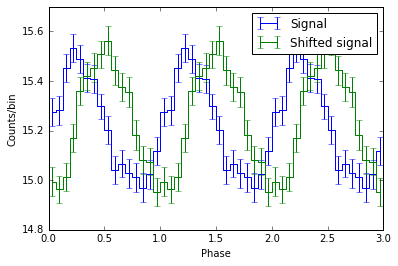

In [21]:
def epoch_folding(time, signal, period, nperiods=3, nbin=16):
    # The phase of the pulse is always between 0 and 1.
    phase = time / period
    #phase -= phase.astype(int)
    phase -= floor(phase)
    
    # First histogram: divide phase range in nbin bins, and count how many signal bins
    # fall in each histogram bin. The sum is weighted by the value of the signal at 
    # each phase
    prof_raw, bins = histogram(phase, bins=linspace(0, 1, nbin + 1),
                               weights=signal)
    # "Exposure": how many signal bins have been summed in each histogram bin
    expo, bins = histogram(phase, bins=linspace(0, 1, nbin + 1))
    
    # ---- Evaluate errors -------
    prof_sq, bins = histogram(phase, bins=linspace(0, 1, nbin + 1),
                              weights=signal ** 2)
    # Variance of histogram bin: "Mean of squares minus square of mean" X N
    hist_var = (prof_sq / expo - (prof_raw / expo) ** 2) * expo
    # Then, take square root -> Stdev, then normalize / N. 
    prof_err = sqrt(hist_var)
    #-----------------------------
    # Normalize by exposure
    prof = prof_raw / expo
    prof_err = prof_err / expo
    
    # histogram returns all bin edges, including last one. Here we take the
    # center of each bin.
    phase_bins = (bins[1:] + bins[:-1]) / 2
    
    # ---- Return the same pattern 'nperiods' times, for visual purposes -----
    final_prof = array([])
    final_phase = array([])
    final_prof_err = array([])
    for n in range(nperiods):
        final_prof = append(final_prof, prof)
        final_phase = append(final_phase, phase_bins + n)
        final_prof_err = append(final_prof_err, prof_err)
    # ---------------------------
    return final_phase, final_prof, final_prof_err

phase, profile, profile_err = epoch_folding(time, total, period)
phase_shift, profile_shift, profile_shift_err = epoch_folding(time, signal_shift, period)

errorbar(phase, profile, yerr=profile_err, drawstyle='steps-mid', label='Signal')
errorbar(phase_shift, profile_shift, yerr=profile_shift_err, drawstyle='steps-mid', label='Shifted signal')

_ = legend()
_ = xlabel('Phase')
_ = ylabel('Counts/bin')

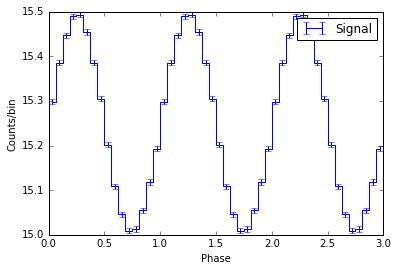

In [30]:
time = arange(0, 10000, time_bin) + time_bin / 2
signal = pulsar(time, period)
signal = random.normal(pulsar_amp * signal, pulsar_stdev)
# plot(time, signal, 'r-', label='signal')
noise = random.normal(noise_amp, noise_stdev, len(time))
total = signal + noise

phase, profile, profile_err = epoch_folding(time, total, period)
# phase_shift, profile_shift, profile_shift_err = epoch_folding(time, signal_shift, period)

errorbar(phase, profile, yerr=profile_err, drawstyle='steps-mid', label='Signal')
# errorbar(phase_shift, profile_shift, yerr=profile_shift_err, drawstyle='steps-mid', label='Shifted signal')

_ = legend()
_ = xlabel('Phase')
_ = ylabel('Counts/bin')

# Epoch folding search

Now, let's run epoch folding at a number of trial periods around the pulse period. To evaluate how much a given profile "looks pulsar-y", we can use the $\chi^2$ statistics, as follows:

\begin{equation}
\mathcal{S} = \sum_{i=0}^N \frac{(p_i - \bar{p})^2}{\sigma_p^2}
\end{equation}

and show the peak at the right period$^1$. [Exercise: do you know what statistics this is? And why does that statistics work for our case? Exercise-2: Note the very large number of trials. Can we optimize the search so that we use less trials without losing sensitivity?]

$^1$ 1.	Leahy, D. A. et al. On searches for pulsed emission with application to four globular cluster X-ray sources - NGC 1851, 6441, 6624, and 6712. _ApJ_ **266**, 160 (1983).

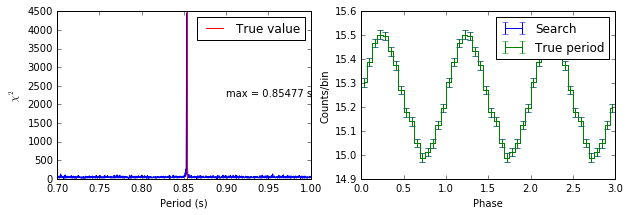

In [32]:
def pulse_profile_stat(profile, profile_err):
    return sum((profile - mean(profile)) ** 2 / profile_err ** 2)

time = arange(0, 1000, time_bin) + time_bin / 2
signal = pulsar(time, period)
signal = random.normal(pulsar_amp * signal, pulsar_stdev)
# plot(time, signal, 'r-', label='signal')
noise = random.normal(noise_amp, noise_stdev, len(time))
total = signal + noise

trial_periods = arange(0.7, 1.0, 0.0002)
stats = zeros_like(trial_periods)
for i, p in enumerate(trial_periods):
    phase, profile, profile_err = epoch_folding(time, total, p)
    stats[i] = pulse_profile_stat(profile, profile_err)

bestp = trial_periods[argmax(stats)]

fig = figure(figsize=(10, 3))
gs = gridspec.GridSpec(1, 2)
ax = subplot(gs[0])
ax.plot(trial_periods, stats)
ax.set_xlim([0.7, 1])
ax.set_xlabel('Period (s)')
ax.set_ylabel('$\chi^2$')
ax.axvline(period, color='r', label="True value")
_ = ax.legend()
ax.annotate('max = {:.5f} s'.format(pmax), xy=(.9, max(stats) / 2))

ax2 = subplot(gs[1])
phase_search, profile_search, profile_search_err = epoch_folding(time, total, bestp)
phase, profile, profile_err = epoch_folding(time, total, period)


ax2.errorbar(phase_search, profile_search, yerr=profile_search_err, drawstyle='steps-mid', label='Search')
ax2.errorbar(phase, profile, yerr=profile_err, drawstyle='steps-mid', label='True period')
ax2.set_xlabel('Phase')
ax2.set_ylabel('Counts/bin')

_ = ax2.legend()


# Times of arrival (TOA)
To calculate the time of arrival of the pulses, we need to:

* Choose what **part of the pulse** is the reference (e.g., the maximum). Once we know that, if $\phi_{max}$ is the phase of the maximum of the pulse, $t_{start}$ the time at the start of the folded light curve, and $p$ is the folding period,

$TOA = t_{start} + \phi_{max} \cdot p$

* Choose a **method** to calculate the TOA: 

  + The maximum bin?
  
  + The phase of a sinusoidal fit?
  
  + The phase of a more complicated fit?
 
Hereafter, we are going to use the maximum of the pulse as a reference, and we will calculate the TOA with the three methods above. 

## TOA from the maximum bin

**Advantage**

* Very fast and easy to implement

**Disadvantages**

* Very rough (maximum precision, the width of the bin)

* Very uncertain (if statistics is low and/or the pulse is broad, many close-by bins can randomly be the maximum)

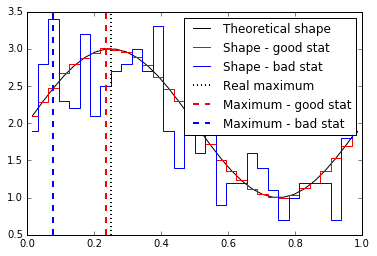

In [35]:
phase_bin = 1 / 32.
ph = arange(phase_bin / 2, phase_bin / 2 + 1, phase_bin)
shape = sin(2 * pi * ph) + 2
pr_1 = random.poisson(shape * 10000) / 10000
pr_2 = random.poisson(shape * 10) / 10

plot(ph, shape, label='Theoretical shape', color='k')
plot(ph, pr_1, drawstyle='steps-mid', color='r', label='Shape - good stat')
plot(ph, pr_2, drawstyle='steps-mid', color='b', label='Shape - bad stat')
axvline(0.25, ls=':', color='k', lw=2, label='Real maximum')
axvline(ph[argmax(pr_1)], ls='--', color='r', lw=2, label='Maximum - good stat')
axvline(ph[argmax(pr_2)], ls='--', color='b', lw=2, label='Maximum - bad stat')

_ = legend()

## TOA from single sinusoidal fit

**Advantage**

* Relatively easy task (fitting with a sinusoid)

* Errors are well determined provided that the pulse is broad

**Disadvantages**

* If profile is not sinusoidal, might not be well determined

Below, the phase of the pulse is always 0.25

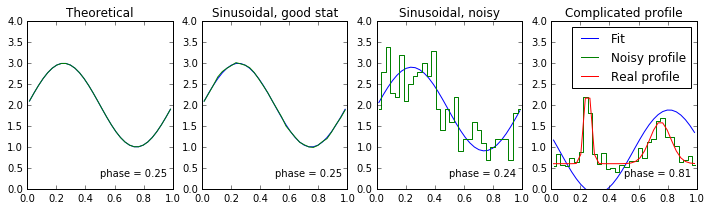

In [36]:
def sinusoid(phase, phase0, amplitude, offset):
    return offset + cos(2 * pi * (phase - phase0))

from scipy.optimize import curve_fit

fig = figure(figsize=(12, 3))
gs = gridspec.GridSpec(1, 4)
ax1 = subplot(gs[0])
ax1.set_title('Theoretical')

# Fit sinusoid to theoretical shape
par, pcov = curve_fit(sinusoid, ph, shape)
ax1.plot(ph, sinusoid(ph, *par))
ax1.plot(ph, shape)
par[0] -= floor(par[0])
ax1.annotate('phase = {:.2f}'.format(par[0]), xy=(.5, .3))
ax1.set_ylim([0, 4])

# Fit to good-stat line
ax2 = subplot(gs[1])
ax2.set_title('Sinusoidal, good stat')

par, pcov = curve_fit(sinusoid, ph, pr_1)
ax2.plot(ph, sinusoid(ph, *par))
ax2.plot(ph, pr_1)
par[0] -= floor(par[0])
ax2.annotate('phase = {:.2f}'.format(par[0]), xy=(.5, .3))
ax2.set_ylim([0, 4])

# Fit to bad-stat line
ax3 = subplot(gs[2])
ax3.set_title('Sinusoidal, noisy')

par, pcov = curve_fit(sinusoid, ph, pr_2)
ax3.plot(ph, sinusoid(ph, *par))
ax3.plot(ph, pr_2, drawstyle='steps-mid')
par[0] -= floor(par[0])
ax3.annotate('phase = {:.2f}'.format(par[0]), xy=(.5, .3))
ax3.set_ylim([0, 4])

# Now try with a complicated profile (a double Gaussian)
ax4 = subplot(gs[3])
ax4.set_title('Complicated profile')
pr_3_clean = 0.3 + exp(- (ph - 0.25) ** 2 / 0.001) + 0.5 * exp(- (ph - 0.75) ** 2 / 0.01)
pr_3 = random.poisson(pr_3_clean * 100) / 50
# Let us normalize the template with the same factor (100 / 50) of the randomized one. It will be helpful later
pr_3_clean *= 2

par, pcov = curve_fit(sinusoid, ph, pr_3, maxfev=10000)
ax4.plot(ph, sinusoid(ph, *par), label='Fit')
ax4.plot(ph, pr_3, drawstyle='steps-mid', label='Noisy profile')
ax4.plot(ph, pr_3_clean, label='Real profile')

par[0] -= floor(par[0])
ax4.annotate('phase = {:.2f}'.format(par[0]), xy=(.5, .3))
ax4.set_ylim([0, 4])
_ = ax4.legend()

## TOA from non-sinusoidal fit: multiple harmonic fitting

**Multiple harmonic fitting**$^1$ (the profile is described by a sum of sinusoids) is just an extension of the single-harmonic fit by adding additional sinusoidal components at multiple frequencies.

**Advantages**

* Still conceptually easy, but more robust and reliable

**Disadvantages**

* The phase is not determined by the fit (in general, it isn't he phase of any of the sinusoids [Exercise: why?]) and needs to be determined from the maximum of the profile. Errors are not straightforward to implement.

$^1$e.g. Riggio, A. et al. Timing of the accreting millisecond pulsar IGR J17511-3057. _A&A_ **526**, 95 (2011).


## TOA from non-sinusoidal fit: Template pulse shapes

* ~~**Straightforward fit of a template**~~ (Tricky because of periodicity -> discarded)

* **Cross-correlation** of template pulse shape

* **Fourier-domain fitting (FFTFIT)**$^1$ -> the usual choice. Consists of taking the Fourier transform of the profile $\mathcal{P}$ and of the template $\mathcal{T}$ and minimizing the following objective function (similar to $\chi^2$):
\begin{equation}
F = \sum_k \frac{|\mathcal{P}_k - a\mathcal{T}_k e^{-2\pi i k\phi}|^2}{\sigma^2}
\end{equation}

**Advantages**

* Much more robust and reliable

* Errors well determined whatever the pulse shape

**Disadvantages**

* Relatively trickier to implement

* Needs good template pulse profile

$^1$Taylor, J. H. Pulsar Timing and Relativistic Gravity. _Philosophical Transactions: Physical Sciences and Engineering_ **341**, 117–134 (1992).

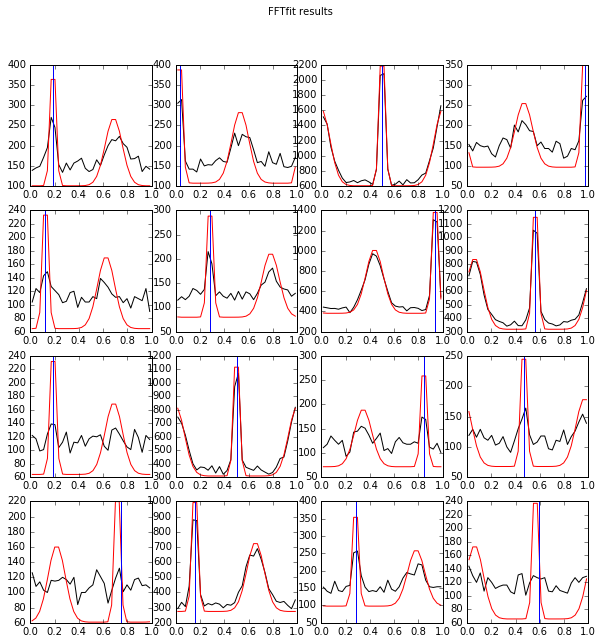

In [37]:
def fftfit_fun(profile, template, amplitude, phase):
    '''Objective function to be minimized - \'a la Taylor (1992).'''
    
    prof_ft = fft.fft(profile)
    temp_ft = fft.fft(template)
    freq = fft.fftfreq(len(profile))
    good = freq > 0
    idx = arange(0, len(prof_ft), dtype=int)
    sigma = std(prof_ft[good])
    return sum(absolute(prof_ft - temp_ft*amplitude*exp(-2*pi*1.0j*idx*phase))**2 / sigma)

def obj_fun(pars, data):
    '''Wrap parameters and input data up in order to be used with minimization
    algorithms.'''
    amplitude, phase = pars
    profile, template = data
    return fftfit_fun(profile, template, amplitude, phase)

# Produce 16 realizations of pr_3, at different amplitudes and phases, and reconstruct the phase
from scipy.optimize import fmin, basinhopping
fig = figure(figsize=(10, 10))
fig.suptitle('FFTfit results')
gs = gridspec.GridSpec(4, 4)
amp0 = 1
phase0 = 0
p0 = [amp0, phase0]
for i in range(16):
    col = i % 4
    row = i // 4
    
    factor = 10 ** random.uniform(1, 3)
    pr_orig = random.poisson(pr_3_clean * factor + 100)
    roll_len = random.randint(0, len(pr_orig) - 1)
    pr = roll(pr_orig, roll_len)

    # Using generic minimization algorithms is faster, but local minima can be a problem
#    res = fmin(obj_fun, p0, args=([pr, pr_3_clean],), disp=False, full_output=True)
#    amplitude_res, phase_res = res[0]

    # The basinhopping algorithm is very slow but very effective in finding 
    # the global minimum of functions with local minima.
    res = basinhopping(obj_fun, p0, minimizer_kwargs={'args':([pr, pr_3_clean],)})
    amplitude_res, phase_res = res.x
    
    phase_res -= floor(phase_res)

    ax = subplot(gs[row, col])
    ax.plot(ph, pr, 'k-')

    newphase = ph + phase_res
    newphase -= floor(newphase)
    
    # Sort arguments of phase so that they are ordered in plot
    # (avoids ugly lines traversing the plot)
    order = argsort(newphase)
    
    ax.plot(newphase[order], amplitude_res * pr_3_clean[order], 'r-')
    ph_max = 0.25 + roll_len / len(pr_orig)
    ax.axvline(ph_max - floor(ph_max))

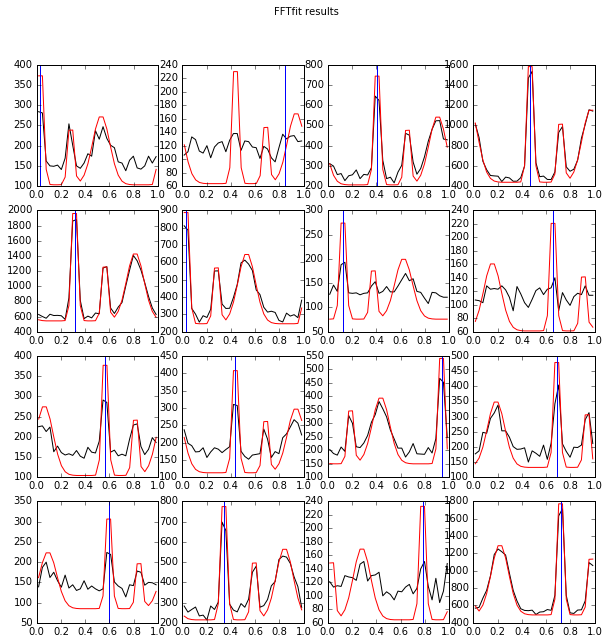

In [38]:
pr_3_clean = 0.3 + exp(- (ph - 0.25) ** 2 / 0.001) + 0.5 * exp(- (ph - 0.75) ** 2 / 0.01)+ 0.5 * exp(- (ph - 0.5) ** 2 / 0.001)
# Let us normalize the template with the same factor (100 / 50) of the randomized one. It will be helpful later
pr_3_clean *= 2

fig = figure(figsize=(10, 10))
fig.suptitle('FFTfit results')
gs = gridspec.GridSpec(4, 4)
amp0 = 1
phase0 = 0
p0 = [amp0, phase0]
for i in range(16):
    col = i % 4
    row = i // 4
    
    factor = 10 ** random.uniform(1, 3)
    pr_orig = random.poisson(pr_3_clean * factor + 100)
    roll_len = random.randint(0, len(pr_orig) - 1)
    pr = roll(pr_orig, roll_len)

    # Using generic minimization algorithms is faster, but local minima can be a problem
#    res = fmin(obj_fun, p0, args=([pr, pr_3_clean],), disp=False, full_output=True)
#    amplitude_res, phase_res = res[0]

    # The basinhopping algorithm is very slow but very effective in finding 
    # the global minimum of functions with local minima.
    res = basinhopping(obj_fun, p0, minimizer_kwargs={'args':([pr, pr_3_clean],)})
    amplitude_res, phase_res = res.x
    
    phase_res -= floor(phase_res)

    ax = subplot(gs[row, col])
    ax.plot(ph, pr, 'k-')

    newphase = ph + phase_res
    newphase -= floor(newphase)
    
    # Sort arguments of phase so that they are ordered in plot
    # (avoids ugly lines traversing the plot)
    order = argsort(newphase)
    
    ax.plot(newphase[order], amplitude_res * pr_3_clean[order], 'r-')
    ph_max = 0.25 + roll_len / len(pr_orig)
    ax.axvline(ph_max - floor(ph_max))